In [ ]:
import torch
import numpy as np
import einops
from tqdm.auto import tqdm

from mist_dataset import MISTDataset
from her2match_dataset import HER2MatchDataset
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

device = torch.device('cuda:2')

## Load UNI

In [2]:
import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

timm_kwargs = {
            'img_size': 224, 
            'patch_size': 14, 
            'depth': 24,
            'num_heads': 24,
            'init_values': 1e-5, 
            'embed_dim': 1536,
            'mlp_ratio': 2.66667*2,
            'num_classes': 0, 
            'no_embed_class': True,
            'mlp_layer': timm.layers.SwiGLUPacked, 
            'act_layer': torch.nn.SiLU, 
            'reg_tokens': 8, 
            'dynamic_img_size': True
        }
uni_model = timm.create_model("hf-hub:MahmoodLab/UNI2-h", pretrained=True, **timm_kwargs)
uni_transform = create_transform(**resolve_data_config(uni_model.pretrained_cfg, model=uni_model))
uni_model.eval()
uni_model.to(device);

## Load PixCell-1024 + LoRA

In [ ]:
from peft import LoraConfig
from pixcell_transformer_2d_lora import PixCellTransformer2DModelLoRA
from diffusers import AutoencoderKL
from diffusers import DPMSolverMultistepScheduler

# Load VAE and scheduler -- same as PixCell-1024
sd3_vae = AutoencoderKL.from_pretrained("stabilityai/stable-diffusion-3.5-large", subfolder="vae")
sd3_vae.to(device)
scheduler = DPMSolverMultistepScheduler.from_pretrained("StonyBrook-CVLab/PixCell-1024", subfolder="scheduler")

# Create transformer and add LoRA adapter
config = {
  "_class_name": "PixCellTransformer2DModel",
  "_diffusers_version": "0.32.2",
  "_name_or_path": "pixart_1024/transformer",
  "activation_fn": "gelu-approximate",
  "attention_bias": True,
  "attention_head_dim": 72,
  "attention_type": "default",
  "caption_channels": 1536,
  "caption_num_tokens": 16,
  "cross_attention_dim": 1152,
  "dropout": 0.0,
  "in_channels": 16,
  "interpolation_scale": 2,
  "norm_elementwise_affine": False,
  "norm_eps": 1e-06,
  "norm_num_groups": 32,
  "norm_type": "ada_norm_single",
  "num_attention_heads": 16,
  "num_embeds_ada_norm": 1000,
  "num_layers": 28,
  "out_channels": 32,
  "patch_size": 2,
  "sample_size": 128,
  "upcast_attention": False,
  "use_additional_conditions": False,
}

# Create new transformer
transformer = PixCellTransformer2DModelLoRA(
    **config
)
# Add LoRA to cross-attention layers
target_modules = [
    "attn2.add_k_proj",
    "attn2.add_q_proj",
    "attn2.add_v_proj",
    "attn2.to_add_out",
    "attn2.to_k",
    "attn2.to_out.0",
    "attn2.to_q",
    "attn2.to_v",
]
rank = 4
lora_dropout = 0.0
transformer_lora_config = LoraConfig(
    r=rank,
    lora_alpha=rank,
    lora_dropout=lora_dropout,
    init_lora_weights="gaussian",
    target_modules=target_modules,
)
transformer.add_adapter(transformer_lora_config)


In [63]:
from huggingface_hub import hf_hub_download

# Load LoRA weights -- specific to each dataset
# lora_model = "ckpts/lora/mist_her2_lora.pth"
# lora_model = "ckpts/lora/mist_er_lora.pth"
# lora_model = "ckpts/lora/mist_pr_lora.pth"
lora_model = "ckpts/lora/mist_ki67_lora.pth"
# lora_model = "ckpts/lora/her2match_lora.pth"

cache_dir = hf_hub_download(
    repo_id="StonyBrook-CVLab/pixcell-virutal-staining",
    filename=lora_model,
    local_dir="downloads/",
)

transformer.load_state_dict(torch.load(cache_dir, map_location='cpu'))
transformer.to(device);

## Load dataset

In [ ]:
# MIST
dataset = MISTDataset(
    root_dir='/path/to/MIST/dataset',
    stain='Ki67',
    split='val'
)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=1)

# HER2Match
# dataset = HER2MatchDataset(
#     root_dir="/path/to/HER2Match/dataset",
#     split='test'
# )
# dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=1)

Found 1000 images in split Ki67/val


## Run inference using real embeddings

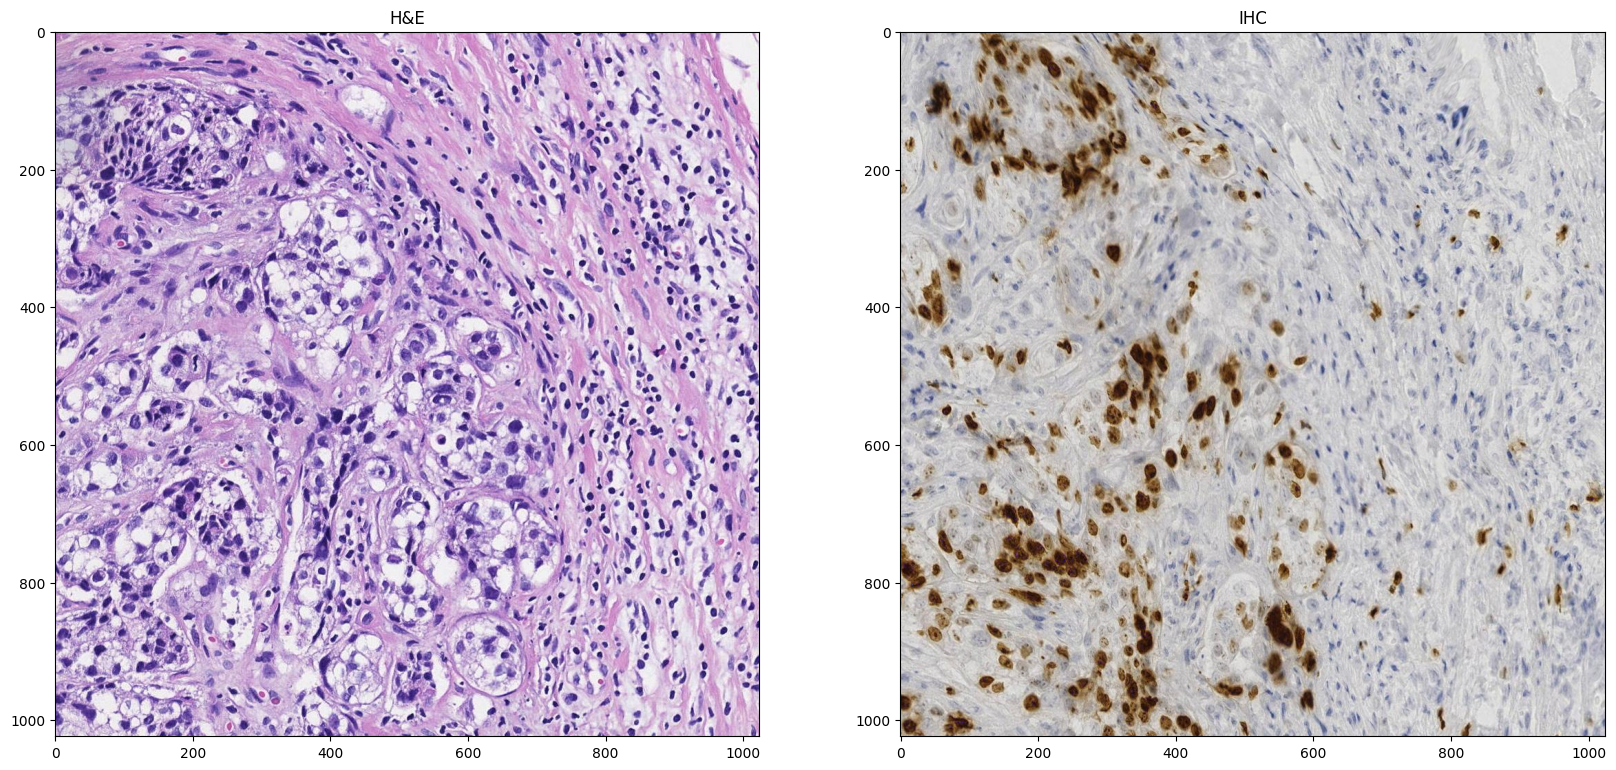

In [68]:
# Draw random pair
he, ihc = next(iter(dataloader))

fig, ax = plt.subplots(1, 2, figsize=(20,10))
ax[0].imshow(he[0].permute([1,2,0]).cpu())
ax[0].set_title("H&E")
ax[1].imshow(ihc[0].permute([1,2,0]).cpu())
ax[1].set_title("IHC")
plt.show()

In [69]:
# Extract UNI features from IHC
# Rearrange 1024x1024 image into 16 256x256 patches
uni_patches = einops.rearrange(ihc, 'b c (d1 h) (d2 w) -> (b d1 d2) c h w', d1=4, d2=4)
uni_input = uni_transform(uni_patches)

# Extract UNI embeddings
with torch.inference_mode():
    uni_emb_ihc = uni_model(uni_input.to(device))

# reshape UNI to (bs, 16, D)
uni_emb_ihc = uni_emb_ihc.unsqueeze(0).reshape(he.shape[0],16,-1)
print("Extracted UNI:", uni_emb_ihc.shape)

Extracted UNI: torch.Size([1, 16, 1536])


In [ ]:
num_inference_steps = 20
guidance_scale = 1.2

# Sample IHC image using extracted IHC embeddings
uncond = transformer.caption_projection.uncond_embedding.clone().tile(uni_emb_ihc.shape[0],1,1)
print('UNI conditioning:', uni_emb_ihc.shape)

vae_scale = sd3_vae.config.scaling_factor
vae_shift = getattr(sd3_vae.config, "shift_factor", 0)

xt = torch.randn((1,16,128,128), device=device)
scheduler.set_timesteps(num_inference_steps, device=device)
timesteps = scheduler.timesteps

for tt in tqdm(timesteps):
    current_timestep = torch.tensor([tt]).to(device)
    with torch.no_grad():
        with torch.autocast('cuda'):
            epsilon = transformer(
                xt,
                encoder_hidden_states=uni_emb_ihc,
                timestep=current_timestep,
                return_dict=False,
            )[0][:,:16,:,:]

        if guidance_scale > 1.0:
            with torch.autocast('cuda'):
                epsilon_uncond = transformer(
                    xt,
                    encoder_hidden_states=uncond.to(device),
                    timestep=current_timestep,
                    return_dict=False,
                )[0][:,:16,:,:]

            epsilon = epsilon_uncond + guidance_scale*(epsilon - epsilon_uncond)

    xt = scheduler.step(epsilon, tt, xt, return_dict=False)[0]

with torch.no_grad():
    gen_image = sd3_vae.decode((xt / vae_scale) + vae_shift, return_dict=False)[0]
    gen_image = (0.5*(gen_image+1)).clamp(0,1)[0].permute([1,2,0]).cpu().numpy()

fig, ax = plt.subplots(1, 3, figsize=(30,10))
ax[0].imshow(he[0].permute([1,2,0]).cpu())
ax[0].set_title("H&E")
ax[1].imshow(ihc[0].permute([1,2,0]).cpu())
ax[1].set_title("IHC")
ax[2].imshow(gen_image)
ax[2].set_title(f"Generated IHC | Real UNI")
plt.show()

## Run inference using inferred embeddings

In [71]:
from resmlp import SimpleMLP

# Flow-matching MLP that transforms H&E UNI embeedings to IHC UNI embeddings
uni_mlp = SimpleMLP(
    in_channels=1536,
    time_embed_dim=1024,
    model_channels=1024,
    bottleneck_channels=1024,
    out_channels=1536,
    num_res_blocks=6,
).to(device)


In [72]:
# Load flow MLP weights -- specific to each dataset
# mlp_model = "ckpts/mlp/mist_her2_mlp.pth"
# mlp_model = "ckpts/mlp/mist_er_mlp.pth"
# mlp_model = "ckpts/mlp/mist_pr_mlp.pth"
mlp_model = "ckpts/mlp/mist_ki67_mlp.pth"
# mlp_model = "ckpts/mlp/her2match_mlp.pth"

cache_dir = hf_hub_download(
    repo_id="StonyBrook-CVLab/pixcell-virutal-staining",
    filename=mlp_model,
    local_dir="downloads/",
)

uni_mlp.load_state_dict(torch.load(cache_dir, map_location='cpu'))
uni_mlp.to(device)
uni_mlp.eval();

In [73]:
# Transform embeddings

# Extract UNI features from H&E
# Rearrange 1024x1024 image into 16 256x256 patches
uni_patches = einops.rearrange(he, 'b c (d1 h) (d2 w) -> (b d1 d2) c h w', d1=4, d2=4)
uni_input = uni_transform(uni_patches)

# Extract UNI embeddings
with torch.inference_mode():
    uni_emb_he = uni_model(uni_input.to(device))

# reshape UNI to (bs, 16, D)
uni_emb_he = uni_emb_he.unsqueeze(0).reshape(he.shape[0],16,-1)
print("Extracted UNI:", uni_emb_he.shape)

# Euler
uni_ihc_flow = uni_emb_he.clone().reshape(-1,1536).to(device)
n_steps = 100
dt = 1/n_steps
eps = 1e-3
for t in np.linspace(0+eps, 1-eps, n_steps):
    with torch.no_grad():
        pred = uni_mlp(uni_ihc_flow, 999*torch.tensor(he.shape[0]*16*[t]).to(device)) #, context=cond)
        uni_ihc_flow = uni_ihc_flow + dt*pred

uni_ihc_flow = uni_ihc_flow.reshape(he.shape[0],16,1536)
print("Generated UNI:", uni_ihc_flow.shape)

Extracted UNI: torch.Size([1, 16, 1536])
Generated UNI: torch.Size([1, 16, 1536])


UNI conditioning: torch.Size([1, 16, 1536])


100%|██████████| 20/20 [00:04<00:00,  4.21it/s]


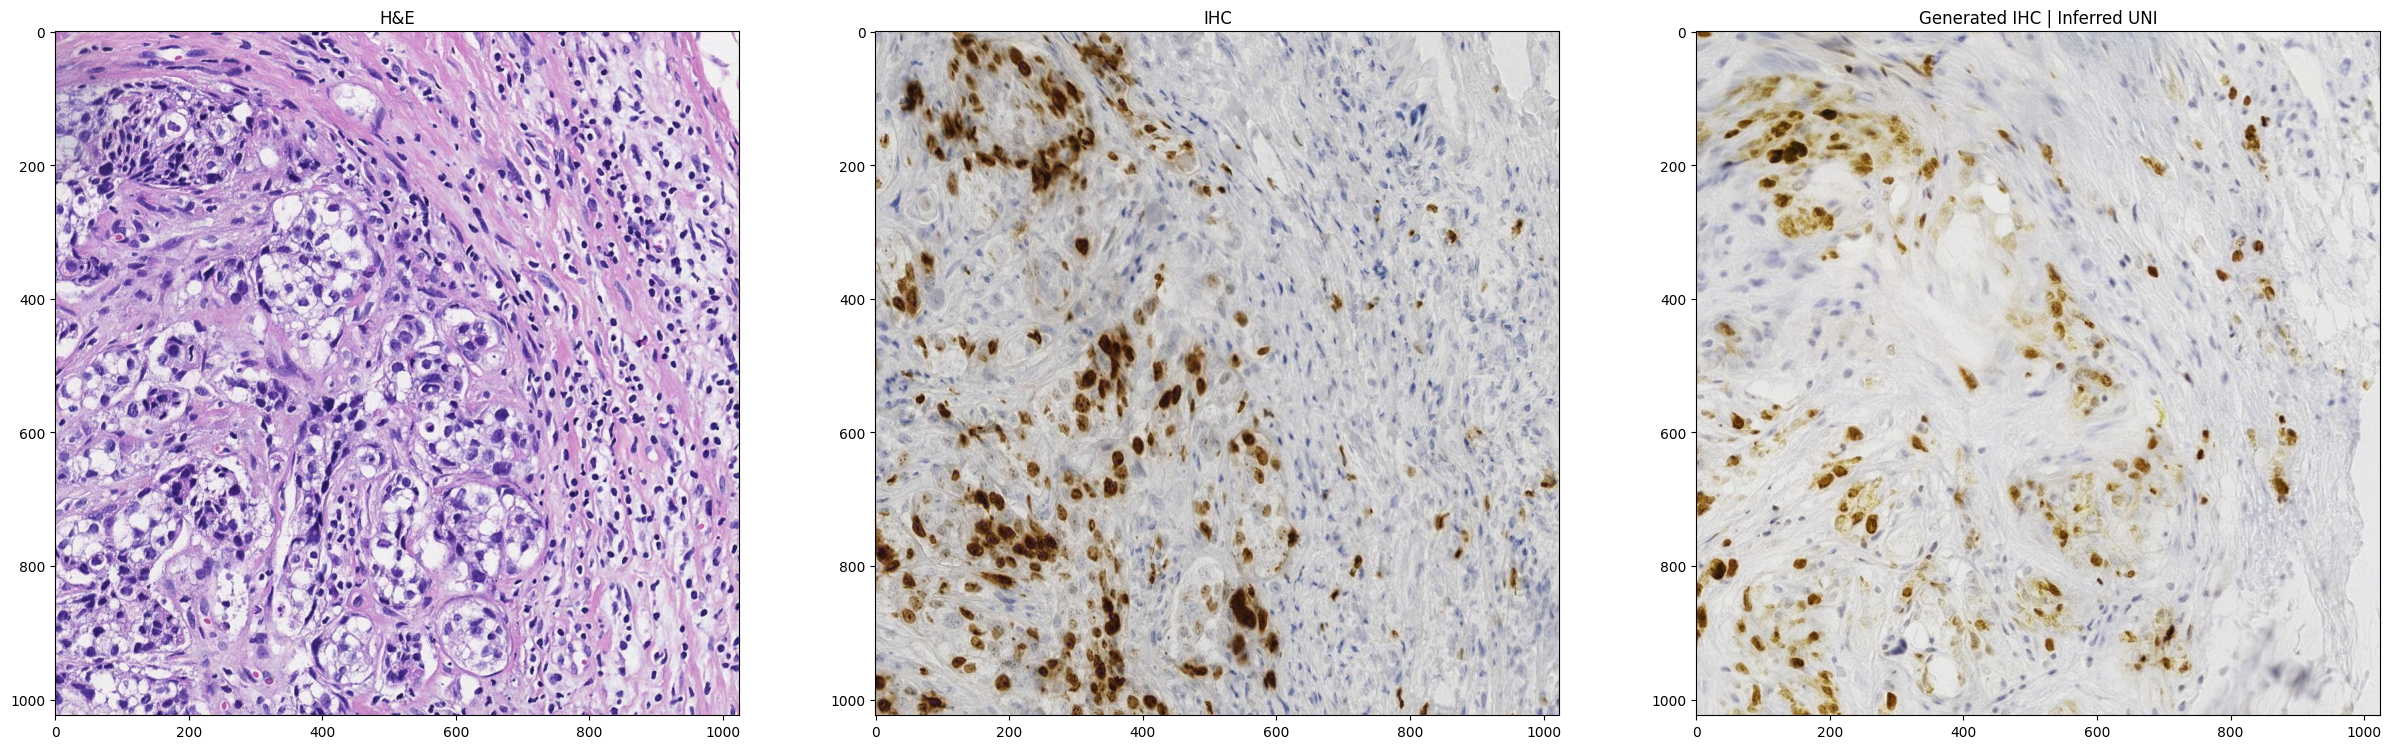

In [74]:
num_inference_steps = 20
guidance_scale = 1.2

# Sample IHC image using extracted IHC embeddings
uncond = transformer.caption_projection.uncond_embedding.clone().tile(uni_ihc_flow.shape[0],1,1)
print('UNI conditioning:', uni_ihc_flow.shape)

vae_scale = sd3_vae.config.scaling_factor
vae_shift = getattr(sd3_vae.config, "shift_factor", 0)

xt = torch.randn((1,16,128,128), device=device)
scheduler.set_timesteps(num_inference_steps, device=device)
timesteps = scheduler.timesteps

for tt in tqdm(timesteps):
    current_timestep = torch.tensor([tt]).to(device)
    with torch.no_grad():
        with torch.autocast('cuda'):
            epsilon = transformer(
                xt,
                encoder_hidden_states=uni_ihc_flow,
                timestep=current_timestep,
                return_dict=False,
            )[0][:,:16,:,:]

        if guidance_scale > 1.0:
            with torch.autocast('cuda'):
                epsilon_uncond = transformer(
                    xt,
                    encoder_hidden_states=uncond.to(device),
                    timestep=current_timestep,
                    return_dict=False,
                )[0][:,:16,:,:]

            epsilon = epsilon_uncond + guidance_scale*(epsilon - epsilon_uncond)

    xt = scheduler.step(epsilon, tt, xt, return_dict=False)[0]

with torch.no_grad():
    gen_image = sd3_vae.decode((xt / vae_scale) + vae_shift, return_dict=False)[0]
    gen_image = (0.5*(gen_image+1)).clamp(0,1)[0].permute([1,2,0]).cpu().numpy()

fig, ax = plt.subplots(1, 3, figsize=(30,10))
ax[0].imshow(he[0].permute([1,2,0]).cpu())
ax[0].set_title("H&E")
ax[1].imshow(ihc[0].permute([1,2,0]).cpu())
ax[1].set_title("IHC")
ax[2].imshow(gen_image)
ax[2].set_title(f"Generated IHC | Inferred UNI")
plt.show()